In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")


In [2]:
df_model = pd.read_csv("../data/processed/bina_rent_model.csv")
print(df_model.shape)
df_model.head()


(14113, 11)


,rooms,area_m2,floor_current,floor_total,price,district,floor_ratio,building_type_enc,is_baku,district_freq,district_target_enc
0,4,105,9,17,580,Xırdalan,0.529412,1,0,334,459.200599
1,1,50,17,17,549,20 Yanvar m.,1.000000,1,1,620,771.066129
2,3,80,3,5,699,Gənclik m.,0.600000,0,1,521,966.310940
3,2,50,1,2,800,Nizami m.,0.500000,0,1,752,1187.590426
4,3,90,9,12,750,Koroğlu m.,0.750000,1,1,43,915.581395


In [3]:
X = df_model.drop(columns=["price"])
y = df_model["price"]


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [5]:
district_mean = y_train.groupby(X_train["district"]).mean()

X_train["district_target_enc"] = X_train["district"].map(district_mean)
X_test["district_target_enc"] = X_test["district"].map(district_mean)

X_test["district_target_enc"] = X_test["district_target_enc"].fillna(y_train.mean())

X_train.drop(columns=["district"], inplace=True)
X_test.drop(columns=["district"], inplace=True)


In [6]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [7]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)


In [8]:
mlp_model = MLPRegressor(
    hidden_layer_sizes=(128, 64, 32),
    activation="relu",
    solver="adam",
    alpha=0.0005,
    learning_rate_init=0.001,
    max_iter=500,
    random_state=42,
    early_stopping=True
)

mlp_model.fit(X_train_scaled, y_train_log)


,"loss loss: {'squared_error', 'poisson'}, default='squared_error'The loss function to use when training the weights. Note that the""squared error"" and ""poisson"" losses actually implement""half squares error"" and ""half poisson deviance"" to simplify thecomputation of the gradient. Furthermore, the ""poisson"" loss internally usesa log-link (exponential as the output activation function) and requires``y >= 0``... versionchanged:: 1.7 Added parameter `loss` and option 'poisson'.",'squared_error'
,"hidden_layer_sizes hidden_layer_sizes: array-like of shape(n_layers - 2,), default=(100,)The ith element represents the number of neurons in the ithhidden layer.","(128, ...)"
,"activation activation: {'identity', 'logistic', 'tanh', 'relu'}, default='relu'Activation function for the hidden layer.- 'identity', no-op activation, useful to implement linear bottleneck, returns f(x) = x- 'logistic', the logistic sigmoid function, returns f(x) = 1 / (1 + exp(-x)).- 'tanh', the hyperbolic tan function, returns f(x) = tanh(x).- 'relu', the rectified linear unit function, returns f(x) = max(0, x)",'relu'
,"solver solver: {'lbfgs', 'sgd', 'adam'}, default='adam'The solver for weight optimization.- 'lbfgs' is an optimizer in the family of quasi-Newton methods.- 'sgd' refers to stochastic gradient descent.- 'adam' refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy BaFor a comparison between Adam optimizer and SGD, see:ref:`sphx_glr_auto_examples_neural_networks_plot_mlp_training_curves.py`.Note: The default solver 'adam' works pretty well on relativelylarge datasets (with thousands of training samples or more) in terms ofboth training time and validation score.For small datasets, however, 'lbfgs' can converge faster and performbetter.",'adam'
,"alpha alpha: float, default=0.0001Strength of the L2 regularization term. The L2 regularization termis divided by the sample size when added to the loss.",0.0005
,"batch_size batch_size: int, default='auto'Size of minibatches for stochastic optimizers.If the solver is 'lbfgs', the regressor will not use minibatch.When set to ""auto"", `batch_size=min(200, n_samples)`.",'auto'
,"learning_rate learning_rate: {'constant', 'invscaling', 'adaptive'}, default='constant'Learning rate schedule for weight updates.- 'constant' is a constant learning rate given by 'learning_rate_init'.- 'invscaling' gradually decreases the learning rate ``learning_rate_`` at each time step 't' using an inverse scaling exponent of 'power_t'. effective_learning_rate = learning_rate_init / pow(t, power_t)- 'adaptive' keeps the learning rate constant to 'learning_rate_init' as long as training loss keeps decreasing. Each time two consecutive epochs fail to decrease training loss by at least tol, or fail to increase validation score by at least tol if 'early_stopping' is on, the current learning rate is divided by 5.Only used when solver='sgd'.",'constant'
,"learning_rate_init learning_rate_init: float, default=0.001The initial learning rate used. It controls the step-sizein updating the weights. Only used when solver='sgd' or 'adam'.",0.001
,"power_t power_t: float, default=0.5The exponent for inverse scaling learning rate.It is used in updating effective learning rate when the learning_rateis set to 'invscaling'. Only used when solver='sgd'.",0.5
,"max_iter max_iter: int, default=200Maximum number of iterations. The solver iterates until convergence(determined by 'tol') or this number of iterations. For stochasticsolvers ('sgd', 'adam'), note that this determines the number of epochs(how many times each data point will be used), not the number ofgradient steps.",500
,"shuffle shuffle: bool, default=TrueWhether to shuffle samples in each iteration. Only used whensolver='sgd' or 'adam'.",True


In [9]:
train_pred_log = mlp_model.predict(X_train_scaled)
test_pred_log = mlp_model.predict(X_test_scaled)

train_pred = np.expm1(train_pred_log)
test_pred = np.expm1(test_pred_log)


In [10]:
def eval_metrics(y_true, y_pred, name=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name} → MAE: {mae:.2f} | RMSE: {rmse:.2f} | R2: {r2:.3f}")

eval_metrics(y_train, train_pred, "Train MLP")
eval_metrics(y_test, test_pred, "Test MLP")


Train MLP → MAE: 172.20 | RMSE: 264.78 | R2: 0.661
Test MLP → MAE: 178.61 | RMSE: 273.46 | R2: 0.638


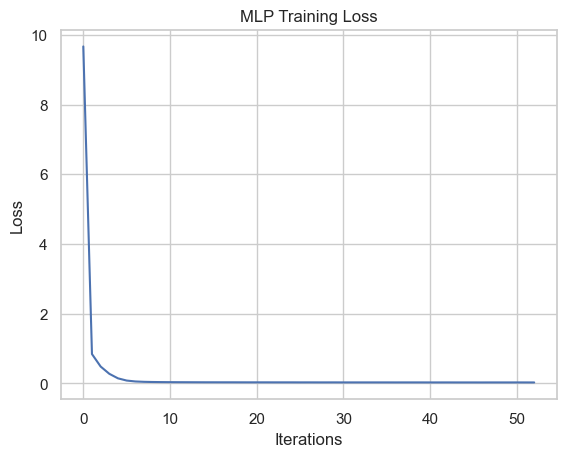

In [11]:
plt.plot(mlp_model.loss_curve_)
plt.title("MLP Training Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()
